## Data Preprocessing


First few rows:
                            md5hash  fitzpatrick_scale  fitzpatrick_centaur  \
0  fd06d13de341cc75ad679916c5d7e6a6                  4                    4   
1  a4bb4e5206c4e89a303f470576fc5253                  1                    1   
2  c94ce27e389f96bda998e7c3fa5c4a2e                  5                    5   
3  ebcf2b50dd943c700d4e2b586fcd4425                  3                    3   
4  c77d6c895f05fea73a8f3704307036c0                  1                    1   

                              label nine_partition_label  \
0                 prurigo-nodularis     benign-epidermal   
1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                            keloid         inflammatory   
3              basal-cell-carcinoma  malignant-epidermal   
4                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  
0                benign           NaN         34  
1             malignant           NaN        

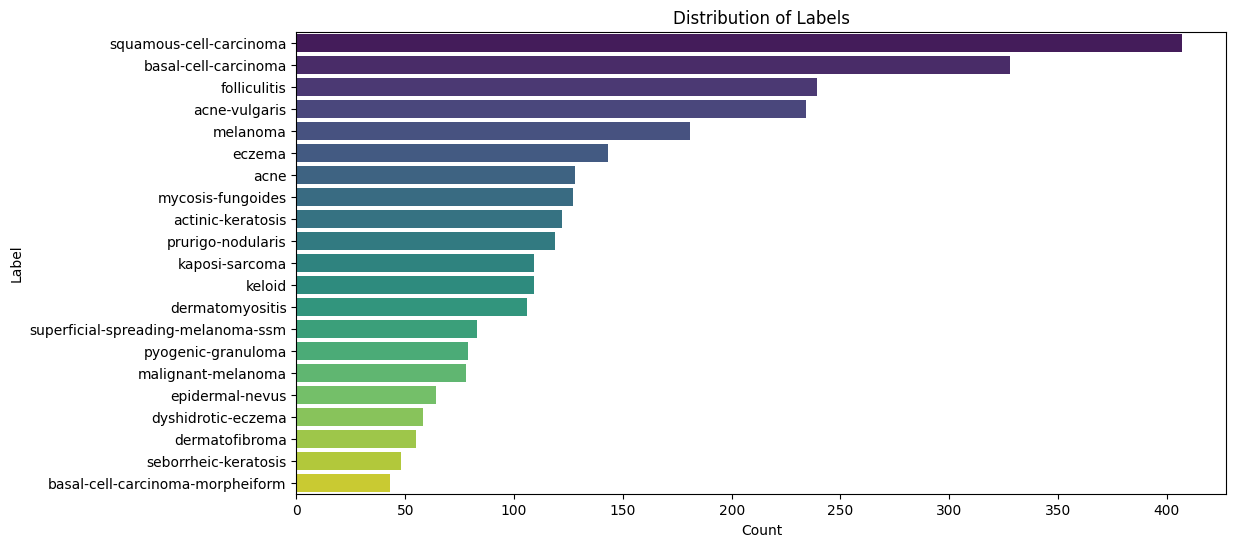

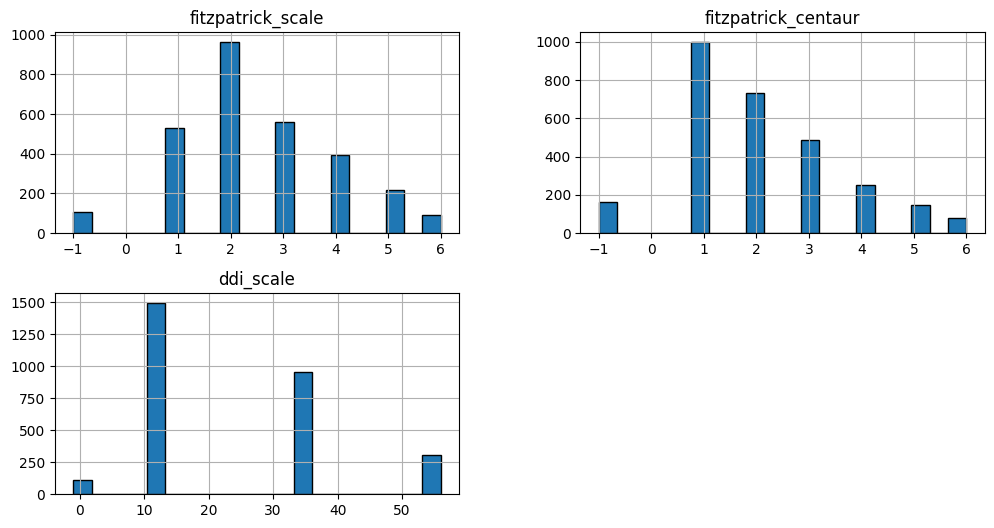

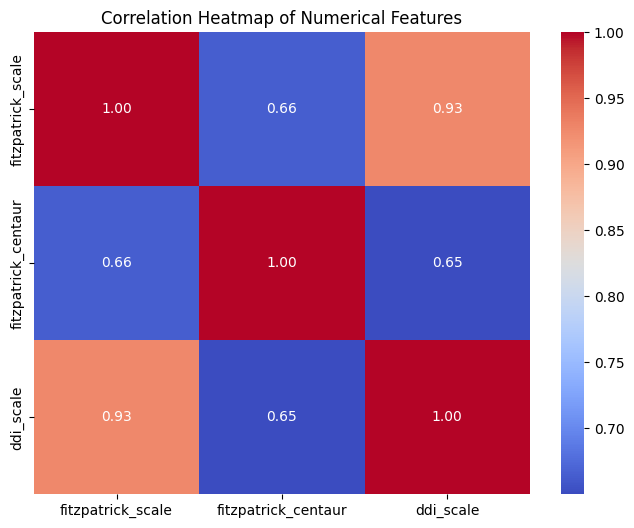

In [1]:
## Exploratory Data Analysis (EDA)
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/kaggle/input/bttai-ajl-2025/train.csv"
df = pd.read_csv(file_path)

# Display first few rows
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Plot label distribution
plt.figure(figsize=(12,6))
sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette='viridis')
plt.title("Distribution of Labels")
plt.xlabel("Count")
plt.ylabel("Label")
plt.show()

# Visualize numerical features
numerical_cols = ['fitzpatrick_scale', 'fitzpatrick_centaur', 'ddi_scale']
df[numerical_cols].hist(figsize=(12, 6), bins=20, edgecolor='black')

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [2]:
# Count occurrences of -1 in 'fitzpatrick_centaur' and 'fitzpatrick_scale'
total_centaur_negative_ones = (df['fitzpatrick_centaur'] == -1).sum()
total_scale_negative_ones = (df['fitzpatrick_scale'] == -1).sum()

# Display the results
print(f"Total number of -1 values in 'fitzpatrick_centaur': {total_centaur_negative_ones}")
print(f"Total number of -1 values in 'fitzpatrick_scale': {total_scale_negative_ones}")

Total number of -1 values in 'fitzpatrick_centaur': 161
Total number of -1 values in 'fitzpatrick_scale': 108


In [3]:
# Drop rows with fitzpatrick values of -1
train_df = df[(df['fitzpatrick_centaur'] != -1) & (df['fitzpatrick_scale'] != -1)]
print(train_df['fitzpatrick_centaur'].unique())
print(train_df['fitzpatrick_scale'].unique())
print(train_df.shape)

[4 1 5 3 2 6]
[4 1 5 3 2 6]
(2643, 8)


In [4]:
# Check types of columns
train_df.dtypes

md5hash                  object
fitzpatrick_scale         int64
fitzpatrick_centaur       int64
label                    object
nine_partition_label     object
three_partition_label    object
qc                       object
ddi_scale                 int64
dtype: object

In [5]:
# Drop rows with qc values of 2, 3, 4, or 5
rows_with_qc = train_df.dropna(subset = ['qc'])
train_df['qc_num_values'] = rows_with_qc['qc'].str.split().str[0].astype(int)
train_df = train_df[~train_df['qc_num_values'].isin([2, 3, 4, 5])].drop(columns = ['qc_num_values'])
print(train_df['qc'].unique())
print(train_df.shape)

[nan '1 Diagnostic']
(2629, 8)


<ipython-input-5-ee2d4aca1d84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['qc_num_values'] = rows_with_qc['qc'].str.split().str[0].astype(int)


In [6]:
# Drop qc column because most values are NA
train_df.drop(columns = ['qc'], inplace = True)
train_df.columns #Make sure column was properly dropped

Index(['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label',
       'nine_partition_label', 'three_partition_label', 'ddi_scale'],
      dtype='object')

In [7]:
# Check how many classes are in the dataset
train_df['label'].nunique()
train_df['label'].unique()

array(['prurigo-nodularis', 'basal-cell-carcinoma-morpheiform', 'keloid',
       'basal-cell-carcinoma', 'seborrheic-keratosis', 'eczema',
       'squamous-cell-carcinoma', 'actinic-keratosis',
       'mycosis-fungoides', 'folliculitis', 'acne-vulgaris',
       'dyshidrotic-eczema', 'melanoma', 'epidermal-nevus',
       'malignant-melanoma', 'pyogenic-granuloma', 'dermatofibroma',
       'kaposi-sarcoma', 'acne', 'dermatomyositis',
       'superficial-spreading-melanoma-ssm'], dtype=object)

## Ensure Data is Compatible with YOLO

In [8]:
# 2. Load Data
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [9]:
# Define dataset paths
base_dir = "/kaggle/working/dataset"  # Change based on your environment
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Kaggle input dataset path correction
kaggle_train_path = "/kaggle/input/bttai-ajl-2025/train/train/"  # FIXED: Corrected path
kaggle_test_path = "/kaggle/input/bttai-ajl-2025/test/test/"      # FIXED: Corrected path

## Train and Install YOLO Model

In [10]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 23.2 MB/s eta 0:00:0000:01


In [21]:
from ultralytics import YOLO
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
import itertools

# 1. Dataset Preparation (as is)
def prepare_yolo_classification_dataset(csv_path, images_dir, output_dir, val_split=0.2):
    df = pd.read_csv(csv_path)
    df['md5hash'] = df['md5hash'].astype(str) + '.jpg'
    df = df[['md5hash', 'label']]
    train_df, val_df = train_test_split(df, test_size=val_split, stratify=df['label'], random_state=42)

    for split_name, split_df in zip(['train', 'val'], [train_df, val_df]):
        split_dir = os.path.join(output_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)
        
        for label in split_df['label'].unique():
            os.makedirs(os.path.join(split_dir, label), exist_ok=True)
        
        for _, row in split_df.iterrows():
            img_filename = row['md5hash']
            class_name = row['label']
            img_path = os.path.join(images_dir, class_name, img_filename)
            
            if os.path.exists(img_path):
                new_image_path = os.path.join(output_dir, split_name, class_name, img_filename)
                shutil.copy(img_path, new_image_path)
    
    print("Dataset converted to YOLO classification format.")

# 2. YOLO Training with Parameter Logging
def train_yolo_with_params(yolo_dataset_path, model_size, epochs, imgsz, run_name):
    model = YOLO(model_size)
    results = model.train(
        data=yolo_dataset_path,
        epochs=epochs,
        imgsz=imgsz,
        project='yolo_sweeps',
        name=run_name,
        exist_ok=True
    )
    return results

# 3. Parameter Sweep
def run_parameter_sweep():
    # Sweep settings
    model_sizes = ["/kaggle/working/yolo11x-cls.pt"]
    epoch_list = [45]
    img_sizes = [224]

    combinations = list(itertools.product(model_sizes, epoch_list, img_sizes))
    print(f"Running {len(combinations)} combinations...")

    for model_size, epochs, imgsz in combinations:
        run_name = f"{model_size.replace('.pt','')}_e{epochs}_img{imgsz}"
        print(f"\n🔧 Training: {run_name}")
        train_yolo_with_params(yolo_output_folder, model_size, epochs, imgsz, run_name)

# 4. Main Execution
csv_file = "/kaggle/input/bttai-ajl-2025/train.csv"
images_folder = "/kaggle/input/bttai-ajl-2025/train/train"
yolo_output_folder = "/kaggle/working/yolo-dataset"

prepare_yolo_classification_dataset(csv_file, images_folder, yolo_output_folder)
run_parameter_sweep()

Dataset converted to YOLO classification format.
Running 1 combinations...

🔧 Training: /kaggle/working/yolo_sweeps/yolo11x-cls_e45_img224/weights/best_e20_img224
Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=classify, mode=train, model=/kaggle/working/yolo_sweeps/yolo11x-cls_e45_img224/weights/best.pt, data=/kaggle/working/yolo-dataset, epochs=20, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo_sweeps, name=best_e20_img224, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_str

train: Scanning /kaggle/working/yolo-dataset/train... 2288 images, 0 corrupt: 100%|██████████| 2288/2288 [00:01<00:00, 1667.14it/s]

train: WARNING ⚠️ /kaggle/working/yolo-dataset/train/malignant-melanoma/29e5519889107e210f878f86e0d17436.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/yolo-dataset/train/squamous-cell-carcinoma/982fec2e9bea78824d6ad7cc77537faf.jpg: corrupt JPEG restored and saved
train: New cache created: /kaggle/working/yolo-dataset/train.cache



val: Scanning /kaggle/working/yolo-dataset/val... 572 images, 0 corrupt: 100%|██████████| 572/572 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolo_sweeps/yolo11x-cls_e45_img224/weights/best_e20_img224
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.69it/s]

                   all      0.654      0.897



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.13it/s]

                   all      0.619      0.885



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.29it/s]

                   all      0.589      0.874



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 11.88it/s]

                   all      0.591      0.871



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 11.85it/s]

                   all      0.598      0.893



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 11.53it/s]

                   all      0.605      0.892



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.44it/s]

                   all      0.629      0.886



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.62it/s]

                   all      0.622      0.892



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 11.63it/s]

                   all      0.624      0.914



      Epoch    GPU_mem       loss  Instances       Size


      10/20      2.93G     0.1723         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.70it/s]

                   all      0.635      0.888



      Epoch    GPU_mem       loss  Instances       Size


      11/20      2.93G     0.2497         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.29it/s]

                   all      0.617      0.897



      Epoch    GPU_mem       loss  Instances       Size


      12/20      2.93G     0.2313         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.46it/s]

                   all      0.635      0.893



      Epoch    GPU_mem       loss  Instances       Size


      13/20      2.93G     0.1745         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.67it/s]

                   all      0.638      0.904



      Epoch    GPU_mem       loss  Instances       Size


      14/20      2.93G      0.146         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.11it/s]

                   all      0.633      0.902



      Epoch    GPU_mem       loss  Instances       Size


      15/20      2.93G     0.1521         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.64it/s]

                   all      0.645      0.906



      Epoch    GPU_mem       loss  Instances       Size


      16/20      2.93G      0.141         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.64it/s]

                   all      0.645      0.907



      Epoch    GPU_mem       loss  Instances       Size


      17/20      2.93G     0.1073         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 11.18it/s]

                   all      0.656      0.902



      Epoch    GPU_mem       loss  Instances       Size


      18/20      2.93G     0.1001         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.72it/s]

                   all      0.657      0.902



      Epoch    GPU_mem       loss  Instances       Size


      19/20      2.93G    0.09214         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.64it/s]

                   all      0.649      0.913



      Epoch    GPU_mem       loss  Instances       Size


      20/20      2.93G    0.07396         16        224: 100%|██████████| 143/143 [00:22<00:00,  6.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.22it/s]

                   all      0.657      0.907



20 epochs completed in 0.140 hours.
Optimizer stripped from /kaggle/working/yolo_sweeps/yolo11x-cls_e45_img224/weights/best_e20_img224/weights/last.pt, 57.1MB
Optimizer stripped from /kaggle/working/yolo_sweeps/yolo11x-cls_e45_img224/weights/best_e20_img224/weights/best.pt, 57.1MB

Validating /kaggle/working/yolo_sweeps/yolo11x-cls_e45_img224/weights/best_e20_img224/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x-cls summary (fused): 94 layers, 28,359,317 parameters, 0 gradients, 110.3 GFLOPs
train: /kaggle/working/yolo-dataset/train... found 2288 images in 21 classes ✅ 
val: /kaggle/working/yolo-dataset/val... found 572 images in 21 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 11.05it/s]
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.657      0.907
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /kaggle/working/yolo_sweeps/yolo11x-cls_e45_img224/weights/best_e20_img224


## Validate and Make Predictions

In [22]:
def load_class_mapping(csv_path):
    """
    Loads class mapping from train.csv to map numerical predictions back to class names.
    
    Args:
        csv_path (str): Path to train.csv.
    
    Returns:
        dict: Mapping of class index to class name.
    """
    df = pd.read_csv(csv_path)
    class_names = sorted(df['label'].unique())
    return {idx: name for idx, name in enumerate(class_names)}
    
def run_yolo_on_test(test_images_dir, model_path, submission_csv, class_mapping):
    """
    Runs trained YOLO model on test set and generates a submission CSV with correct class names.
    
    Args:
        test_images_dir (str): Directory containing test images.
        model_path (str): Path to trained YOLO model.
        submission_csv (str): Path to save submission CSV.
        class_mapping (dict): Dictionary mapping class IDs to class names.
    """
    model = YOLO(model_path)
    test_images = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith('.jpg')]
    
    results = []
    for img_path in test_images:
        pred = model(img_path)[0].probs.top1  # Get top prediction (numerical class ID)
        class_name = class_mapping.get(pred, "Unknown")  # Convert class ID to class name
        results.append([os.path.basename(img_path), class_name])
    
    submission_df = pd.DataFrame(results, columns=['md5hash', 'label'])
    submission_df.to_csv(submission_csv, index=False)
    print("Submission CSV generated:", submission_csv)

# Define test paths
test_images_folder = "/kaggle/input/bttai-ajl-2025/test/test"
trained_model_path = "/kaggle/working/yolo_sweeps/yolo11x-cls_e45_img224/weights/best.pt"
submission_file = "/kaggle/working/submission.csv"
class_mapping = load_class_mapping("/kaggle/input/bttai-ajl-2025/train.csv")

# Run inference and generate submission file
run_yolo_on_test(test_images_folder, trained_model_path, submission_file, class_mapping)


image 1/1 /kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg: 224x224 squamous-cell-carcinoma 0.89, actinic-keratosis 0.09, basal-cell-carcinoma 0.02, eczema 0.00, dyshidrotic-eczema 0.00, 9.6ms
Speed: 4.1ms preprocess, 9.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg: 224x224 basal-cell-carcinoma 0.67, squamous-cell-carcinoma 0.19, actinic-keratosis 0.14, basal-cell-carcinoma-morpheiform 0.00, prurigo-nodularis 0.00, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/input/bttai-ajl-2025/test/test/ee9728f1e771a1922abe13af66282b41.jpg: 224x224 basal-cell-carcinoma 0.97, squamous-cell-carcinoma 0.03, melanoma 0.00, actinic-keratosis 0.00, acne 0.00, 8.5ms
Speed: 3.1ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/input/bttai-ajl-2

In [23]:
submission = pd.read_csv('/kaggle/working/submission.csv')

submission

,md5hash,label
0,e0374ae6c1362ff183cfba28ded5421b.jpg,squamous-cell-carcinoma
1,437159c605260bdd079af230566af291.jpg,basal-cell-carcinoma
2,ee9728f1e771a1922abe13af66282b41.jpg,basal-cell-carcinoma
3,7729a485abc264b1c58a995a49ec7f5b.jpg,malignant-melanoma
4,0bd2ab66f36e69352a45d5122f4aad07.jpg,acne
...,...,...
1222,794572175ce2487d073bcbd2d62f2743.jpg,basal-cell-carcinoma
1223,ca86e26ccedeb67ab344763f929d6bbb.jpg,folliculitis
1224,bb4f6bd8661b8f0a52ccaef5f2fc5b56.jpg,prurigo-nodularis
1225,51b542089596a4d122839b333b656871.jpg,malignant-melanoma


In [25]:
submission['md5hash'] = submission['md5hash'].str.replace('.jpg', '')

submission.to_csv("/kaggle/working/submission.csv", index=False)